In [10]:
import pandas as pd
import dtale
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go # for visualization
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import os
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext nb_black
%load_ext blackcellmagic

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


<IPython.core.display.Javascript object>

In [11]:
df = pd.read_excel("../../../site_info_ver_3.2.xlsx")


<IPython.core.display.Javascript object>

In [12]:
df_sites = []
sites = df.Site_Name.unique()
for site in sites:
    tmp = df[df.Site_Name==site]
    tmp.reset_index(drop=True,inplace=True)
    df_sites.append(tmp)

<IPython.core.display.Javascript object>

Check Null

In [13]:
# df.isna().sum()
# df=df.dropna()
# df.reset_index(inplace=True,drop=True)
for d in df_sites:
    d.drop(['pm10','nox','so2','pm2.5',"Site_Name"],axis=1,inplace=True)
# len(df[df.isnull().any(axis=1)])/len(df)

<IPython.core.display.Javascript object>

Defiend X and y

In [14]:
X_site = []
targets_site = []
for d in df_sites:
    X_site.append(d.drop(['Israelis_Count','Tourists_Count','Total',"Date","Model_number"],axis=1))
    targets_site.append(d[['Israelis_Count','Tourists_Count','Total']])

<IPython.core.display.Javascript object>

Scaleing

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaled_X_sites=[]
scaled_targets_sites=[]
for i in range(len(X_site)):
    #scale X
    scaler = MinMaxScaler()
    scaled_X_sites.append( pd.DataFrame(scaler.fit_transform(X_site[i]), columns=X_site[i].columns))

    #scale y
    scaled_targets_sites.append( np.log(targets_site[i]+0.01))

<IPython.core.display.Javascript object>

Outliers

In [16]:
# c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(scaled_targets_sites[0].columns))]
# fig = go.Figure()
# fig.add_traces(data=[go.Box( 
#     y=scaled_targets_sites[0].iloc[:, i], 
#     marker_color=c[i],
#     name=scaled_targets_sites[0].columns[i])
#     for i in range(len(scaled_targets_sites[0].columns))
#     ])



<IPython.core.display.Javascript object>

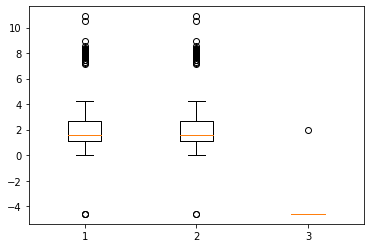

<IPython.core.display.Javascript object>

In [17]:
outliers_I_sites=[]
outliers_To_sites=[]
outliers_Tu_sites=[]

for j in range(len(scaled_targets_sites)):
    plt.cla()
    data=[scaled_targets_sites[j].Israelis_Count,scaled_targets_sites[j].Total,scaled_targets_sites[j].Tourists_Count]
    bp = plt.boxplot(data)
    minimums = [round(item.get_ydata()[0], 4) for item in bp['caps']][::2]
    maximums = [round(item.get_ydata()[0], 4) for item in bp['caps']][1::2]
    outliers_I_sites.append ( scaled_targets_sites[j][(scaled_targets_sites[j].Israelis_Count>maximums[0])  | (scaled_targets_sites[j].Israelis_Count<minimums[0])].index)
    outliers_To_sites.append (scaled_targets_sites[j][(scaled_targets_sites[j].Total>maximums[1]) | (scaled_targets_sites[j].Total<minimums[1])].index)
    outliers_Tu_sites.append (scaled_targets_sites[j][(scaled_targets_sites[j].Tourists_Count>maximums[2]) | (scaled_targets_sites[j].Tourists_Count<minimums[2])].index)

Model MLR with Pollutions droped Null rows

In [18]:
Model_type= "MLR"
res=pd.read_excel("../../../res.xlsx")


for j in range(len(scaled_X_sites)):
  Descripton = "Without Pollutions Without outliers for each site " + sites[j]
  print(sites[j])
  targets = [scaled_targets_sites[j].Israelis_Count,scaled_targets_sites[j].Total,scaled_targets_sites[j].Tourists_Count] # get target info of this site
  targets_list_name = ['Israelis_Count','Total','Tourists_Count']
  idx=0
  for y in targets:

      #split the data, train the model and get prediction for the training and for the test  
      #######################################################################################################################
      X=scaled_X_sites[j] # get X info of this site
      # for outliers 
      if idx==0:
        X=X.drop(outliers_I_sites[j])
        y.drop(outliers_I_sites[j],inplace=True)
      elif idx==1:
        X=X.drop(outliers_To_sites[j])
        y.drop(outliers_To_sites[j],inplace=True)
      # else :
      #   X=X.drop(outliers_Tu_sites[j])
      #   y.drop(outliers_Tu_sites[j],inplace=True)
      print(len(X),len(y),len(outliers_To_sites[j]))
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=312148513)
      train_df_scaled = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
      test_df_scaled = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)

      lm = LinearRegression()  # define our model using least square method
      lm.fit(X_train,y_train)   # Fit our linear model

      #train
      fitted = np.exp(lm.predict(X_train))
      predicted_train = round(pd.Series(fitted, index=y_train.index, name='Predicted_train_'+targets_list_name[idx]),ndigits=2)
      orignal_train=np.exp(train_df_scaled[[targets_list_name[idx]]])
      train_df = pd.merge(left=orignal_train, right=predicted_train, left_index=True, right_index=True)
      train_df

      #test
      fitted = np.exp(lm.predict(X_test))
      predicted_test = round(pd.Series(fitted, index=y_test.index, name='Predicted_test_'+targets_list_name[idx]),ndigits=2)
      orignal_test = np.exp(test_df_scaled[[targets_list_name[idx]]])
      test_df = pd.merge(left=orignal_test, right=predicted_test, left_index=True, right_index=True)
      test_df
       #######################################################################################################################





       #plot the residuals graph
       #######################################################################################################################

       #calculate the residuals
      test_df['residuals'] = test_df['Predicted_test_'+targets_list_name[idx]] - test_df[targets_list_name[idx]]
      train_df['residuals'] = train_df['Predicted_train_'+targets_list_name[idx]] - train_df[targets_list_name[idx]]

      fig= go.Figure()
      fig.add_trace(
        go.Scatter(
            x=train_df['Predicted_train_'+targets_list_name[idx]],
            y=train_df.residuals,
            mode='markers',
            name='train residuals',
            marker_color='blue',
            marker_size=1.5,
            marker_line_width=0,
         )
       )
      fig.add_trace(
        go.Scatter(
            x=test_df['Predicted_test_'+targets_list_name[idx]],
            y=test_df.residuals,
            mode='markers',
            name='test residuals',
            marker_color='red',
            marker_size=1.5,
            marker_line_width=0,
         )
       )
      fig.add_trace(
         go.Scatter(
            x=test_df['Predicted_test_'+targets_list_name[idx]],
            y=test_df.residuals*0,
            mode='lines',
            name='zero line',
            marker_color='black',
            marker_size=1.5,
            marker_line_width=0,
         )
       )
      fig.update_layout(
          title="Residuals of Predicted "+targets_list_name[idx],
          xaxis_title="Predicted "+targets_list_name[idx],
          yaxis_title="Residuals",
          font=dict(
              size=14,
              color="RebeccaPurple"
          )
      )
      # fig.show()
       #######################################################################################################################

       #create folder
       ########################################
      if not os.path.exists(sites[j]):
        os.mkdir(sites[j])

      if not os.path.exists(sites[j]+'/'+Descripton):
        os.mkdir(sites[j]+'/'+Descripton)
      fig.write_image(sites[j]+'/'+Descripton+"/results_"+targets_list_name[idx]+'_.png', width=1500, height=600)
      #########################################

      #create txt file with the metrix result 
      ################################################################################################################################################     
      f = open(sites[j]+'/'+Descripton+"/results_"+targets_list_name[idx]+'_.txt', 'w')

      #  correct_rows = train_df.loc[abs(train_df['Predicted_train_'+targets_list_name[idx]]-train_df[targets_list_name[idx]])<=50].any(axis=1).count()
      #  ACC_Training = round(correct_rows/len(train_df),3)

      MSE_Training = metrics.mean_squared_error(train_df[targets_list_name[idx]], train_df['Predicted_train_'+targets_list_name[idx]])
      RMSE_Training = np.sqrt(metrics.mean_squared_error(train_df[targets_list_name[idx]], train_df['Predicted_train_'+targets_list_name[idx]]))
      MAE_Training = metrics.mean_absolute_error(train_df[targets_list_name[idx]], train_df['Predicted_train_'+targets_list_name[idx]])
      R2_Training=metrics.r2_score(train_df[targets_list_name[idx]], train_df['Predicted_train_'+targets_list_name[idx]])
      std_Training = np.std(predicted_train)

      f.write("------ TRAIN DATA ------\n")
      #f.write("Model "+' mod0' +" Accuracy: "+str(ACC_Training)+"\n")
      f.write("MSE : "+str(MSE_Training)+", RMSE: "+str(RMSE_Training)+", MAE : "+str(MAE_Training)+"\n")
      f.write("R2 TRAIN "+ str(R2_Training)+"\n")


      #  correct_rows = test_df.loc[abs(test_df['Predicted_test_'+targets_list_name[idx]]-test_df[targets_list_name[idx]])<=50].any(axis=1).count()
      #  ACC_Test = round(correct_rows/len(test_df),3)

      MSE_Test = metrics.mean_squared_error(test_df[targets_list_name[idx]], test_df['Predicted_test_'+targets_list_name[idx]])
      RMSE_Test = np.sqrt(metrics.mean_squared_error(test_df[targets_list_name[idx]], test_df['Predicted_test_'+targets_list_name[idx]]))
      MAE_Test = metrics.mean_absolute_error(test_df[targets_list_name[idx]], test_df['Predicted_test_'+targets_list_name[idx]])
      R2_Test = metrics.r2_score(test_df[targets_list_name[idx]], test_df['Predicted_test_'+targets_list_name[idx]])
      std_test = np.std(predicted_test)

      f.write("\n")
      f.write("------ TEST DATA ------\n")
      #f.write("Model "+' mod0' +" Accuracy: "+str(ACC_Test)+"\n")
      f.write("MSE : "+str(MSE_Test)+", RMSE: "+str(RMSE_Test)+", MAE : "+str(MAE_Test)+"\n")
      f.write("R2 TEST "+ str(R2_Test)+"\n")
      f.write("--------------------------------\n")

      f.close()
      ################################################################################################################################################     

      #Add to excel result the new line
      ################################################################################################################################################
      Target=targets_list_name[idx]
      Site_in_this_model=sites[j]
      new_row = {
        'Descripton':Descripton,
        "Target":Target,
        'Model_type':Model_type,
        # 'Model_number':Model_number,
        'Site_in_this_model':Site_in_this_model,
        "Size Train":len(train_df),
        # 'ACC_Training':ACC_Training,
        'MAE_Training':MAE_Training,
        'MSE_Training':MSE_Training,
        'RMSE_Training':RMSE_Training,
        'STD_Training':std_Training,
        'R2_Training':R2_Training,
        "Size Test":len(test_df),
        # 'ACC_Test':ACC_Test,
        'MAE_Test':MAE_Test,
        'MSE_Test':MSE_Test,
        'RMSE_Test':RMSE_Test,
        'STD_Test':std_test,
        'R2_Test':R2_Test 
        }

      res = res.append(new_row,ignore_index=True)
      ################################################################################################################################################     

      # Index for the next target y
      idx+=1


res.to_excel("../../../res.xlsx",index=False)


Alexander Stream-Bet Yannai
1013 1013 46
1013 1013 46
1059 1059 46
Apollonia
1902 1902 14
1895 1895 14
1909 1909 14
Arbel
1876 1876 48
1866 1866 48
1914 1914 48
Avdat
1885 1885 20
1878 1878 20
1898 1898 20
Ayun Stream
1896 1896 22
1897 1897 22
1919 1919 22
Bet Alpha
1691 1691 31
1695 1695 31
1726 1726 31
Bet Guvrin
1892 1892 27
1880 1880 27
1907 1907 27
Bet Shean
1865 1865 69
1846 1846 69
1915 1915 69
Bet Shearim
1771 1771 35
1770 1770 35
1805 1805 35
Caesarea
1865 1865 98


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<IPython.core.display.Javascript object>